## 데이터 불러오기

In [ ]:
import numpy as np
import pandas as pd
import re

In [ ]:
kwangwoon_df=pd.read_csv('combined_blog_reviews.csv',index_col=False)
kakao_df=pd.read_csv('univ_around_quisine_kakao.csv',index_col=False)
naver_df=pd.read_csv('univ_around_quisine_naver.csv',index_col=False)

## Pretrained BERT모델 FineTuning하기


In [ ]:
df=pd.read_csv("naver_all_concat.csv",index_col=False)

In [ ]:
import pandas as pd
import requests
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
from tqdm import tqdm, tqdm_notebook
from transformers import BertModel

from tqdm.notebook import tqdm
import pandas as pd
import urllib.request
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.tag import pos_tag
import re

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation


In [ ]:
#PreTrained Model 불러오기
CHECKPOINT_NAME = 'kykim/bert-kor-base'


In [ ]:
# Data Labeling
df.loc[(df['class'] == "Ad"), 'class'] = 1  # 광고 -> 1
df.loc[(df['class'] == "noAd"), 'class'] = 0  # 진짜 -> 0

data_list = []

for q, label in zip(df['review'], df['class'])  :
    data = []
    data.append(q)
    data.append(label)

    data_list.append(data)

cleand_df=pd.DataFrame(data_list,columns=['review','label'])

In [ ]:
import torch
from transformers import BertTokenizerFast
from torch.utils.data import Dataset, DataLoader


class TokenDataset(Dataset):

    def __init__(self, dataframe, tokenizer_pretrained):
        # sentence, label 컬럼으로 구성된 데이터프레임 전달
        self.data = dataframe
        # Huggingface 토크나이저 생성
        self.tokenizer = BertTokenizerFast.from_pretrained(tokenizer_pretrained)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sentence = self.data.iloc[idx]['review']
        label = self.data.iloc[idx]['label']

        # 토큰화 처리
        tokens = self.tokenizer(
            sentence,                # 1개 문장
            return_tensors='pt',     # 텐서로 반환
            truncation=True,         # 잘라내기 적용
            padding='max_length',    # 패딩 적용
            add_special_tokens=True  # 스페셜 토큰 적용
        )

        input_ids = tokens['input_ids'].squeeze(0)           # 2D -> 1D
        attention_mask = tokens['attention_mask'].squeeze(0) # 2D -> 1D
        token_type_ids = torch.zeros_like(attention_mask)

        # input_ids, attention_mask, token_type_ids 이렇게 3가지 요소를 반환하도록 합니다.
        # input_ids: 토큰
        # attention_mask: 실제 단어가 존재하면 1, 패딩이면 0 (패딩은 0이 아닐 수 있습니다)
        # token_type_ids: 문장을 구분하는 id. 단일 문장인 경우에는 전부 0
        return {
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            'token_type_ids': token_type_ids,
        }, torch.tensor(label)

In [ ]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(cleand_df, test_size = 0.25, random_state = 42)

In [ ]:
# 토크나이저 지정
tokenizer_pretrained = CHECKPOINT_NAME

# train, test 데이터셋 생성
train_data = TokenDataset(train, tokenizer_pretrained)
test_data = TokenDataset(test, tokenizer_pretrained)

# DataLoader로 이전에 생성한 Dataset를 지정하여, batch 구성, shuffle, num_workers 등을 설정합니다.
train_loader = DataLoader(train_data, batch_size=8, shuffle=True, num_workers=8)
test_loader = DataLoader(test_data, batch_size=8, shuffle=True, num_workers=8)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/80.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/344k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/725 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
class CustomBertModel(nn.Module):
    def __init__(self, bert_pretrained, dropout_rate=0.5):
        # 부모클래스 초기화
        super(CustomBertModel, self).__init__()
        # 사전학습 모델 지정
        self.bert = BertModel.from_pretrained(bert_pretrained)
        # dropout 설정
        self.dr = nn.Dropout(p=dropout_rate)
        # 최종 출력층 정의
        self.fc = nn.Linear(768, 2)

    def forward(self, input_ids, attention_mask, token_type_ids):
        # 입력을 pre-trained bert model 로 대입
        output = self.bert(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        # 결과의 last_hidden_state 가져옴
        last_hidden_state = output['last_hidden_state']
        # last_hidden_state[:, 0, :]는 [CLS] 토큰을 가져옴
        x = self.dr(last_hidden_state[:, 0, :])
        # FC 을 거쳐 최종 출력
        x = self.fc(x)
        return x

In [ ]:
# CustomBertModel 생성
bert = CustomBertModel(CHECKPOINT_NAME)
bert.to(device)

pytorch_model.bin:   0%|          | 0.00/476M [00:00<?, ?B/s]

CustomBertModel(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(42000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwi

In [ ]:
# loss 정의: CrossEntropyLoss
loss_fn = nn.CrossEntropyLoss()

# 옵티마이저 정의: bert.paramters()와 learning_rate 설정
optimizer = optim.Adam(bert.parameters(), lr=1e-5)

In [ ]:
# Roc Curve & Confusion Matrix Visualization

import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc, f1_score, precision_score, recall_score
from itertools import cycle
from tqdm import tqdm

def plot_confusion_matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['True','Fake'], yticklabels=['True','Fake'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

def plot_roc_curve(y_true, y_probs, class_names):
    y_probs_positive_class = y_probs[:, 1]

    fpr, tpr, _ = roc_curve(y_true, y_probs_positive_class)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(10, 7))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:0.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()


In [ ]:
from tqdm import tqdm  # Progress Bar 출력
from sklearn.metrics import f1_score

def model_train(model, data_loader, loss_fn, optimizer, device):
    # 모델을 훈련모드로 설정합니다. training mode 일 때 Gradient 가 업데이트 됩니다. 반드시 train()으로 모드 변경을 해야 합니다.
    model.train()

    # loss와 accuracy 계산을 위한 임시 변수입니다. 0으로 초기화합니다.
    running_loss = 0
    corr = 0
    counts = 0

    # 예측 라벨 및 실제 라벨을 저장할 리스트입니다.
    all_preds = []
    all_labels = []

    # 예쁘게 Progress Bar를 출력하면서 훈련 상태를 모니터링하기 위하여 tqdm으로 래핑합니다.
    progress_bar = tqdm(data_loader, unit='batch', total=len(data_loader), mininterval=1)

    # mini-batch 학습을 시작합니다.
    for idx, (inputs, labels) in enumerate(progress_bar):
        # inputs, label 데이터를 device 에 올립니다. (cuda:0 혹은 cpu)
        inputs = {k:v.to(device) for k, v in inputs.items()}
        labels = labels.to(device)

        # 누적 Gradient를 초기화합니다.
        optimizer.zero_grad()

        # Forward Propagation을 진행하여 결과를 얻습니다.
        output = model(**inputs)

        # 손실함수에 output, label 값을 대입하여 손실을 계산합니다.
        loss = loss_fn(output, labels)

        # 오차역전파(Back Propagation)을 진행하여 미분 값을 계산합니다.
        loss.backward()

        # 계산된 Gradient를 업데이트합니다.
        optimizer.step()

        # output의 max(dim=1)은 max probability와 max index를 반환합니다.
        # max probability는 무시하고, max index는 pred에 저장하여 label 값과 대조하여 정확도를 도출합니다.
        _, pred = output.max(dim=1)

        # 예측 라벨과 실제 라벨을 저장합니다.
        all_preds.extend(pred.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

        # 정확히 맞춘 label의 합계를 계산합니다.
        corr += pred.eq(labels).sum().item()
        counts += len(labels)

        # 배치의 전체 loss를 누적합니다.
        running_loss += loss.item() * labels.size(0)

        # 프로그레스바에 학습 상황 업데이트
        progress_bar.set_description(f"training loss: {running_loss / (idx + 1):.5f}, training accuracy: {corr / counts:.5f}")

    # 전체 데이터셋에 대한 평균 손실을 계산합니다.
    avg_loss = running_loss / len(data_loader.dataset)

    # 정확도를 계산합니다.
    acc = corr / len(data_loader.dataset)

    # F1 스코어를 계산합니다.
    f1 = f1_score(all_labels, all_preds, average='weighted')

    # 평균 손실, 정확도, F1 스코어를 반환합니다.
    return avg_loss, acc, f1, all_preds, all_labels

In [ ]:
import torch
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.preprocessing import label_binarize

def model_evaluate(model, data_loader, loss_fn, device):
    model.eval()
    with torch.no_grad():
        running_loss = 0
        corr = 0

        all_preds = []
        all_labels = []
        all_probs = []

        for inputs, labels in data_loader:
            inputs = {k:v.to(device) for k, v in inputs.items()}
            labels = labels.to(device)

            output = model(**inputs)
            _, pred = output.max(dim=1)

            all_preds.extend(pred.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(output.softmax(dim=1).cpu().numpy())

            corr += pred.eq(labels).sum().item()
            running_loss += loss_fn(output, labels).item() * labels.size(0)

        acc = corr / len(data_loader.dataset)
        avg_loss = running_loss / len(data_loader.dataset)

        precision = precision_score(all_labels, all_preds, average='weighted')
        recall = recall_score(all_labels, all_preds, average='weighted')
        f1 = f1_score(all_labels, all_preds, average='weighted')

        return avg_loss, acc, precision, recall, f1, np.array(all_probs), np.array(all_labels)

## 모델 학습


In [ ]:

num_epochs = 5
model_name = 'bert-kor-base'
min_loss = np.inf

results = []
all_val_probs = []
all_val_labels = []

for epoch in range(num_epochs):
    train_loss, train_acc, _, _, _ = model_train(bert, train_loader, loss_fn, optimizer, device)
    val_loss, val_acc, val_precision, val_recall, val_f1, val_probs, val_labels = model_evaluate(bert, test_loader, loss_fn, device)

    if val_loss < min_loss:
        print(f'[INFO] val_loss has been improved from {min_loss:.5f} to {val_loss:.5f}. Saving Model!')
        min_loss = val_loss
        torch.save(bert.state_dict(), f'{model_name}.pth')

    results.append({
        'epoch': epoch + 1,
        'train_loss': train_loss,
        'train_acc': train_acc,
        'val_loss': val_loss,
        'val_acc': val_acc,
        'val_precision': val_precision,
        'val_recall': val_recall,
        'val_f1': val_f1
    })

    all_val_probs.append(val_probs)
    all_val_labels.append(val_labels)

df_results = pd.DataFrame(results)
df_results.to_csv(f'{model_name}_training_results.csv', index=False)

all_val_probs = np.concatenate(all_val_probs, axis=0)
all_val_labels = np.concatenate(all_val_labels, axis=0)



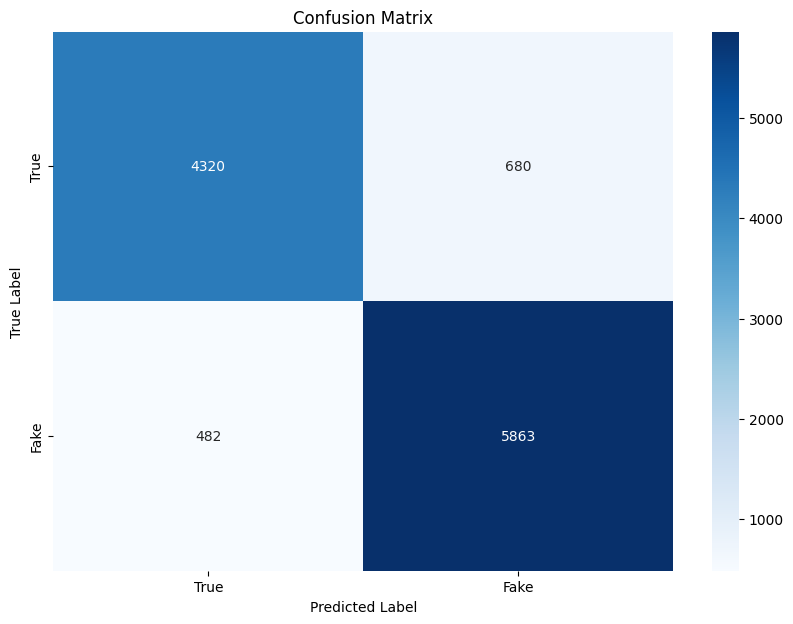

In [ ]:
# Confusion Matrix 시각화
plot_confusion_matrix(all_val_labels, all_val_probs.argmax(axis=1), class_names)


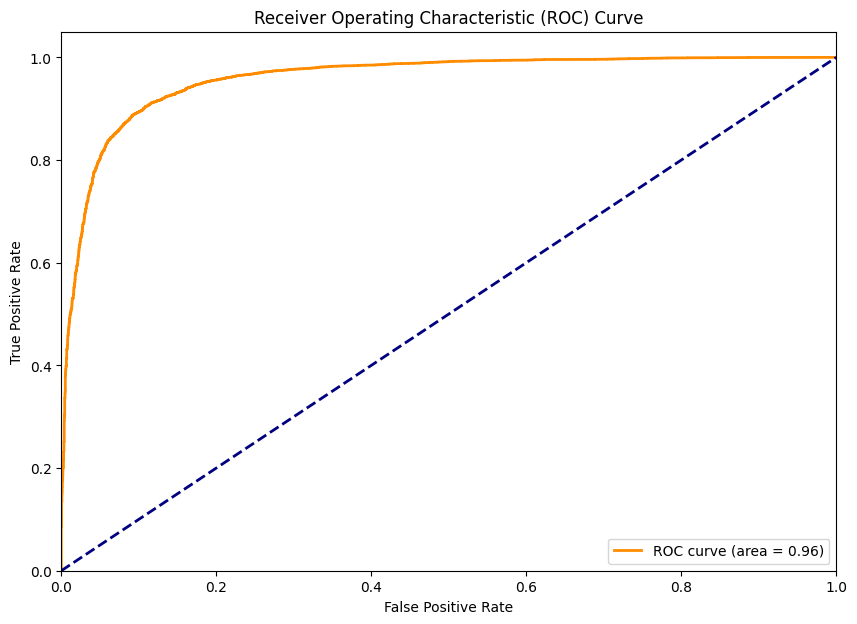

In [ ]:
# ROC CURVE 시각화
plot_roc_curve(all_val_labels, all_val_probs, class_names)

In [ ]:
# Epoch 당 성능 평가
df_results

,epoch,train_loss,train_acc,val_loss,val_acc,val_precision,val_recall,val_f1
0,1,0.427778,0.794710,0.286325,0.878361,0.881466,0.878361,0.877174
1,2,0.262224,0.891256,0.228039,0.906567,0.906684,0.906567,0.906338
2,3,0.166419,0.936076,0.257021,0.909652,0.911933,0.909652,0.908995
3,4,0.097169,0.965026,0.282750,0.906126,0.906429,0.906126,0.906214
4,5,0.052201,0.981043,0.322018,0.905685,0.906213,0.905685,0.905810


In [ ]:
# 학습된 모델 저장
model_path='/content/drive/MyDrive/4학년 1학기/text mining/bert-kor-base.pth'
bert.load_state_dict(torch.load(model_path,map_location=device))


## Real Review Filtering

In [ ]:
ad_review=[]

In [ ]:
# 허위 리뷰 판별 후 식별

class CustomPredictor():
    def __init__(self, model, tokenizer, labels: dict):
        self.model = model
        self.tokenizer = tokenizer
        self.labels = labels

    def predict(self, sentence,index):
        # 토큰화 처리
        tokens = self.tokenizer(
            sentence,                # 1개 문장
            return_tensors='pt',     # 텐서로 반환
            truncation=True,         # 잘라내기 적용
            padding='max_length',    # 패딩 적용
            add_special_tokens=True  # 스페셜 토큰 적용
        )
        tokens.to(device)
        prediction = self.model(**tokens)
        prediction = F.softmax(prediction, dim=1)
        output = prediction.argmax(dim=1).item()
        prob, result = prediction.max(dim=1)[0].item(), self.labels[output]
        if output==1 and prob>0.8:
            ad_review.append([index,sentence])
        print(f'[{result}]\n확률은: {prob*100:.3f}% 입니다.')


In [ ]:
tokenizer = BertTokenizerFast.from_pretrained(CHECKPOINT_NAME)

labels = {
    0: '진짜 리뷰 입니다.',
    1: '광고성 리뷰 입니다.'
}

# CustomPredictor 인스턴스를 생성합니다.
predictor = CustomPredictor(bert, tokenizer, labels)

In [ ]:
# 네이버 & 카카오 리뷰 데이터 합치기
naver_review=pd.read_csv("/content/drive/MyDrive/가게 리뷰 데이터 합치기 완료 최종.csv",index_col=False)
kakao_review=pd.read_csv("/content/drive/MyDrive/using_kakao.csv",index_col=False)
review_df_indexed_concated=pd.concat([naver_review,kakao_review])

In [ ]:
# 사용자 입력에 대하여 예측 후 출력을 낼 수 있는 간단한 함수를 생성합니다.
def predict_sentence(predictor,sente,index):
    input_sentence = sente
    predictor.predict(input_sentence,index)

In [ ]:
long=len(review_df_indexed_concated['리뷰'])

In [ ]:
# 리뷰 판별
for i in range(long):
  predict_sentence(predictor,review_df_indexed_concated['리뷰'][i],review_df_indexed_concated['index'][i])

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
[광고성 리뷰 입니다.]
확률은: 71.689% 입니다.
[진짜 리뷰 입니다.]
확률은: 62.123% 입니다.
[진짜 리뷰 입니다.]
확률은: 60.529% 입니다.
[진짜 리뷰 입니다.]
확률은: 71.111% 입니다.
[진짜 리뷰 입니다.]
확률은: 92.362% 입니다.
[진짜 리뷰 입니다.]
확률은: 70.942% 입니다.
[광고성 리뷰 입니다.]
확률은: 66.599% 입니다.
[광고성 리뷰 입니다.]
확률은: 63.277% 입니다.
[진짜 리뷰 입니다.]
확률은: 99.297% 입니다.
[광고성 리뷰 입니다.]
확률은: 52.139% 입니다.
[진짜 리뷰 입니다.]
확률은: 68.305% 입니다.
[광고성 리뷰 입니다.]
확률은: 63.291% 입니다.
[진짜 리뷰 입니다.]
확률은: 99.509% 입니다.
[진짜 리뷰 입니다.]
확률은: 72.436% 입니다.
[진짜 리뷰 입니다.]
확률은: 78.528% 입니다.
[진짜 리뷰 입니다.]
확률은: 97.077% 입니다.
[진짜 리뷰 입니다.]
확률은: 76.236% 입니다.
[진짜 리뷰 입니다.]
확률은: 73.044% 입니다.
[진짜 리뷰 입니다.]
확률은: 82.443% 입니다.
[광고성 리뷰 입니다.]
확률은: 70.331% 입니다.
[진짜 리뷰 입니다.]
확률은: 53.280% 입니다.
[진짜 리뷰 입니다.]
확률은: 94.060% 입니다.
[진짜 리뷰 입니다.]
확률은: 71.573% 입니다.
[광고성 리뷰 입니다.]
확률은: 54.122% 입니다.
[진짜 리뷰 입니다.]
확률은: 96.015% 입니다.
[광고성 리뷰 입니다.]
확률은: 57.329% 입니다.
[진짜 리뷰 입니다.]
확률은: 61.492% 입니다.
[진짜 리뷰 입니다.]
확률은: 98.461% 입니다.
[진짜 리뷰 입니다.]
확률은: 86.364% 입니다.
[진짜 리뷰 입니다.]
확률은: 81.833% 입니다.
[광고성 리뷰 입니다.]
확률은: 74.115%

index랑 가게이름으로 kakao나 naver에 비교해서 광고성 리뷰 확률 높은것 제거하기.

In [ ]:
ad_review_df=pd.DataFrame(ad_review,columns=['index','review'])

In [ ]:
index_to_drop=ad_review_df['index'].tolist()

In [ ]:
ad_review_df.to_csv("filtered_data_Delete.csv",index=False)

In [ ]:
#가짜 리뷰 모두 네이버의 리뷰로 확인. 네이버 데이터에서 index로 리뷰 데이터 삭제
naver_review_dropped = naver_review.drop(index_to_drop)
naver_review_dropped.to_csv("dropped_naver_review.csv",index=False)

## Blog Review Filtering

In [ ]:
real_blog=pd.read_csv('/content/drive/MyDrive/4학년 1학기/text mining/combined_blog_reviews.csv',index_col=False)
real_blog=real_blog.dropna()

In [ ]:
# 사용자 입력에 대하여 예측 후 출력을 낼 수 있는 간단한 함수를 생성합니다.
def predict_sentence(predictor,sente,index):
    input_sentence = sente
    predictor.predict(input_sentence,index)

In [ ]:
long=len(real_blog['text'])

In [ ]:
ad_review=[]

In [ ]:
# Re Index
index_to_check = 450
if index_to_check in real_blog.index:
    print(f"Index {index_to_check} exists in the DataFrame.")
else:
    print(f"Index {index_to_check} does not exist in the DataFrame.")

real_blog = real_blog.reset_index(drop=True)


Index 450 exists in the DataFrame.


In [ ]:
#판별
for i in range(long):
  predict_sentence(predictor,real_blog['text'][i],i)

[광고성 리뷰 입니다.]
확률은: 62.197% 입니다.
[광고성 리뷰 입니다.]
확률은: 71.775% 입니다.
[광고성 리뷰 입니다.]
확률은: 51.194% 입니다.
[광고성 리뷰 입니다.]
확률은: 69.808% 입니다.
[광고성 리뷰 입니다.]
확률은: 74.227% 입니다.
[광고성 리뷰 입니다.]
확률은: 56.207% 입니다.
[광고성 리뷰 입니다.]
확률은: 85.834% 입니다.
[광고성 리뷰 입니다.]
확률은: 75.014% 입니다.
[광고성 리뷰 입니다.]
확률은: 53.902% 입니다.
[광고성 리뷰 입니다.]
확률은: 65.629% 입니다.
[진짜 리뷰 입니다.]
확률은: 64.442% 입니다.
[광고성 리뷰 입니다.]
확률은: 52.448% 입니다.
[진짜 리뷰 입니다.]
확률은: 54.471% 입니다.
[광고성 리뷰 입니다.]
확률은: 77.546% 입니다.
[광고성 리뷰 입니다.]
확률은: 60.265% 입니다.
[광고성 리뷰 입니다.]
확률은: 50.768% 입니다.
[광고성 리뷰 입니다.]
확률은: 50.350% 입니다.
[광고성 리뷰 입니다.]
확률은: 76.033% 입니다.
[광고성 리뷰 입니다.]
확률은: 83.037% 입니다.
[광고성 리뷰 입니다.]
확률은: 52.876% 입니다.
[광고성 리뷰 입니다.]
확률은: 52.939% 입니다.
[진짜 리뷰 입니다.]
확률은: 54.365% 입니다.
[광고성 리뷰 입니다.]
확률은: 67.716% 입니다.
[광고성 리뷰 입니다.]
확률은: 73.706% 입니다.
[광고성 리뷰 입니다.]
확률은: 75.804% 입니다.
[광고성 리뷰 입니다.]
확률은: 74.742% 입니다.
[광고성 리뷰 입니다.]
확률은: 54.960% 입니다.
[진짜 리뷰 입니다.]
확률은: 73.797% 입니다.
[광고성 리뷰 입니다.]
확률은: 52.701% 입니다.
[광고성 리뷰 입니다.]
확률은: 79.963% 입니다.
[광고성 리뷰 입니다.]
확률은: 68.856% 입니다.
[진짜 리뷰 입니다.]

In [ ]:
# 판별된 광고성 리뷰 삭제.
ad_review_df=pd.DataFrame(ad_review,columns=['index','review'])
inde=ad_review_df['index'].tolist()

In [ ]:
df_dropped = real_blog.drop(inde, axis=0)


In [ ]:
df_dropped.to_csv("filtered_blog_review_kwangwoon.csv",index=False)